<a href="https://colab.research.google.com/github/StrelecTanya/scRNA-Seq_project/blob/main/full_data_pbmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Тема проекта:** Проверка различных программ для батч-коррекции на устойчивость к овер-коррекции



**Задача:** Искуственно создайте два батча, состоящие из (а) абсолютно разных и (б) частично перекрывающихся типов клеток и выполните батч-коррекцию как минимум тремя методами (Harmony, bbknn и третий по выбору) — охарактеризуйте стабильность каждого из рассмотренных вами методов к овер-коррекции батч-эффекта.

# Предобработка данных

In [ ]:
!pip install scanpy[leiden] harmonypy symphonypy bbknn

Загружаем датасет - scRNA-Seq легочной ткани, отобранные от 2х новорожденных девочек

In [ ]:
!gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=T"

Импортируем все необходимые библиотеки для обработки данных

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scanpy.external as sce

In [4]:
adata = sc.read_h5ad("PBMC_Satija.h5ad")
del (
    adata.obs["celltype.l3"],
    adata.obs["Phase"],
    adata.obs["time"],
    adata.obs["lane"],
)

В готовом файле, в adata.X уже предобработанные данные (судя по всему все шаги до шкалирования и отбора HVG). Для более адекватного результата буду работать с сырыми данными и сама их предобработаю.

In [5]:
adata.var["mt"] = adata.var.index.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None,
                           inplace=True, log1p=False)

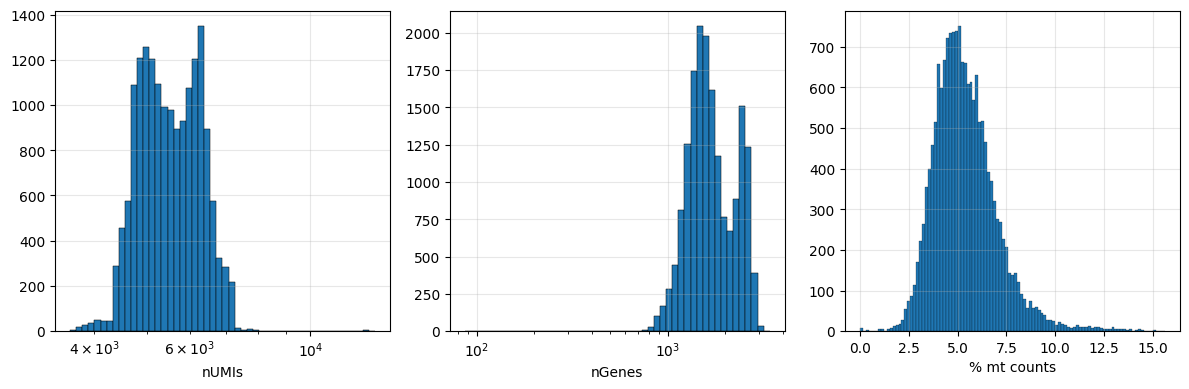

In [6]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sns.histplot(adata.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

fig.tight_layout()

In [7]:
adata = adata[adata.obs.n_genes_by_counts >= 700]

In [8]:
sc.pp.scrublet(adata, batch_key="donor")

In [9]:
adata = adata[adata.obs.doublet_score <= 0.2].copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, batch_key="donor", n_top_genes=3000)

adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [10]:
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, n_comps=30)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Text(0.5, 1.0, 'UMAP по типам клеток')

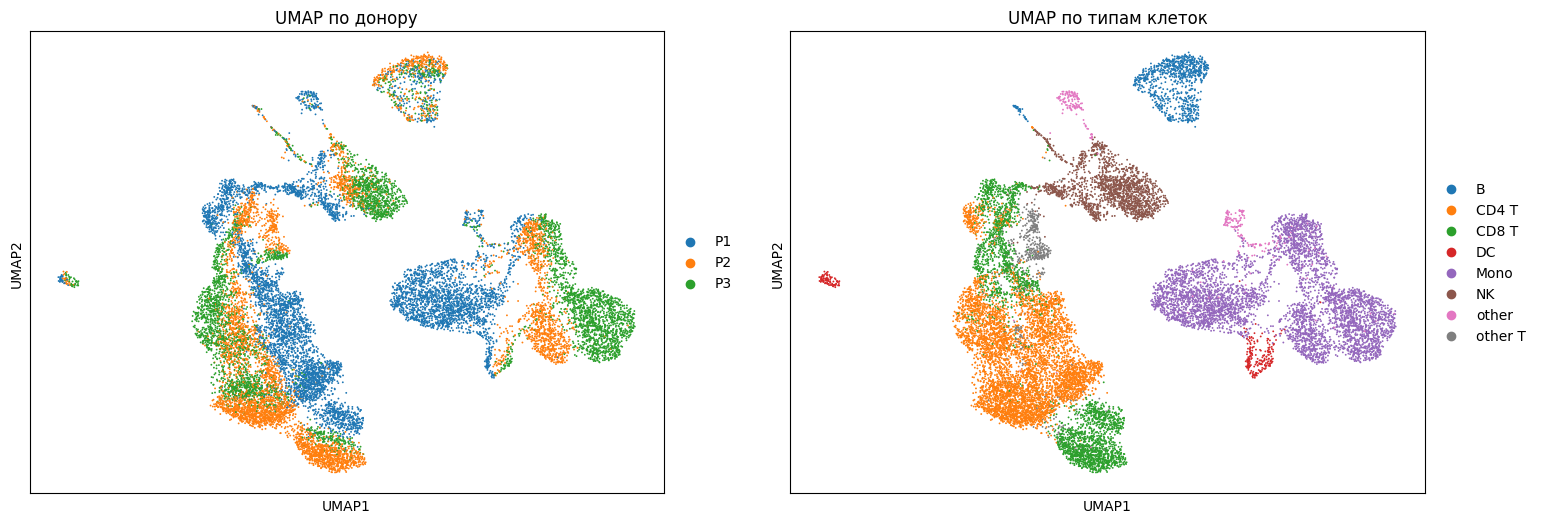

In [11]:
#Визуализация без батч-коррекции
# Предобработка данных
sc.pp.neighbors(adata)
sc.tl.umap(adata)
# Создание подграфиков (subplots)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Увеличиваем ширину фигуры

# Первый график - окрашивание по донору (donor_id)
sc.pl.umap(adata, color='donor', ax=axes[0], show=False)
axes[0].set_title("UMAP по донору")

# Третий график - окрашивание по типам клеток (cell_type)
sc.pl.umap(adata, color="celltype.l1", ax=axes[1], show=False)
axes[1].set_title("UMAP по типам клеток")
